# Set up environment
This cell loads the libraries we need and sets environmentla variables.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import os
import scipy.stats as scp


# set plotting theme/style
sns.set(context='talk', style='white')

# assign study-specific variables
TR = 0.8 # in seconds

project_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/Njenga_project/'
#project_dir = '/Users/sallynjenga/Library/CloudStorage/Box-Box/Njenga_project/'
out_dir = os.path.join(project_dir, 'DATA', 'processed_data')
raw_dir = os.path.join(project_dir, 'DATA', 'raw_data')
vid_dir = os.path.join(project_dir, 'DATA', 'video_data')
sample_file = os.path.join(project_dir, 'DATA', 'helper_files','sample_gord.32k_fs_LR.pscalar.nii')

# get parcel and network labels
parcel_labels = nib.load(sample_file).header.get_axis(1).name
network_labels = []
for s in parcel_labels:
    b = s.split('_')
    if len(b)<2:
        network_labels.append(b[0])
    else:
        network_labels.append(b[1])
network_labels = np.array(network_labels)
network_names, network_sizes = np.unique(network_labels, return_counts=True)

# define measures of interest
networks_of_interest = ['Auditory', 'CinguloOperc', 'Default', 'DorsalAttn', 'FrontoParietal',
                        'SMhand', 'SMmouth', 'Salience', 'VentralAttn', 'Visual']

vidfeat_of_interest = ['Positive','Negative','Brightness','SaliencyFract','Loudness']

# Define functions
These cells store custom functions used in our analyses.

In [2]:
# Compile timeseries data
def compile_ts_data(subdf, movie, datadir, outfile):
    """
    combine timeseries data for each movie together into 1 file
    
    Parameters
    ----------
    subdf: DataFrame
        A dataframe with subject IDs as the index. Includes IDs for all usable data.
    movie: str
        Corresponds with the str for the movie content to concatenate (e.g., "DM" or "TP").
    datadir: folder path
        Path to folder with the subject timeseries ciftis.
    outfile: file path
        Path including filename to save the output data of shape Ntimepoints x Nparcels x Nsubjects.
    
    Returns
    -------
    data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
    """
    from sklearn.preprocessing import StandardScaler
    if not isinstance(subdf, pd.DataFrame):
        subdf = pd.read_csv(subdf, index_col=0)
    
    for sub in subdf.index:
        file = '{0}{1}_task-movie{2}_bold1_AP_Atlas_rescale_resid0.9_filt_gordonseitzman.32k_fs_LR.ptseries.nii'.format(datadir,sub, movie)
        if sub == subdf.index[0]:
            data = StandardScaler().fit_transform(nib.load(file).get_fdata())
            data = np.expand_dims(data, axis=2)
        else:
            t = StandardScaler().fit_transform(nib.load(file).get_fdata())
            t = np.expand_dims(t, axis=2)
            data = np.concatenate([data,t],axis=2)
    
    print('Compile data from {0} brain regions measured at {1} timepoints from {2} participants.'.format(data.shape[1],data.shape[0],data.shape[2]))
    np.save(outfile, data)
    return(data)


def compute_phase(group_ts_data, outfile):
    """
    compute phase angles for each parcel timeseries
    
    Parameters
    ----------
    group_ts_data: filepath OR numpy array
        File or numpy array with compiled timeseries data of shape Ntimepoints x Nparcels x Nsubjects 
        OR Ntimepoints x Nfeatures
    
    Returns
    -------
    phase_data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
    """
    from scipy.signal import hilbert
    from sklearn.preprocessing import StandardScaler
    
    if not isinstance(group_ts_data, np.ndarray):
        group_ts_data = np.load(group_ts_data)
    
    phase_data = np.zeros_like(group_ts_data)
    
    if len(group_ts_data.shape)==3:
        for b in range(0,group_ts_data.shape[2]):
            group_ts_data[:,:,b] = StandardScaler().fit_transform(group_ts_data[:,:,b])
            for a in range(0,group_ts_data.shape[1]):
                phase_data[:,a,b] = np.angle(hilbert(group_ts_data[:,a,b]), deg=False)
    elif len(group_ts_data.shape)==2:
        group_ts_data = StandardScaler().fit_transform(group_ts_data)
        for a in range(0,group_ts_data.shape[1]):
                phase_data[:,a] = np.angle(hilbert(group_ts_data[:,a]), deg=False)
    
    np.save(outfile, phase_data)
    
    return(phase_data)



def compute_ips(group_phase_data, outprefix, intersub=True, interregion=False, savemean=True):
    """
    parcel-wise instantaneous phase synchrony- output pairwise IPS and mean global IPS
    
    Parameters
    ----------
    group_phase_data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
    outprefix: string
        The filepath and file prefix for the saved IPS data.
    intersub: bool
        Set to True to compute intersubject phase synchrony.  Set to False for inter-region.
    interregion: bool
        Set to True to computer inter-region instantaneous phase synchrony. Set to False for intersubject. 
    savemean: bool
        Set to True to save average IPS (across subjects)
        
    Returns
    -------
    ips_data: numpy array
        Instantaneous phase synchrony data of shape Nparcels x Nsubjects x Nsubjects x Ntimepoints 
        OR Nsubjects x Nparcels x Nparcels x Ntimepoints
    mean_ips_data: numpy array
        Instantaneous phase synchrony data, averaged across time, of shape Nparcels x Ntimepoints
        
    """
    import itertools
    
    if not isinstance(group_phase_data, np.ndarray):
        group_phase_data = np.load(group_phase_data)
    
        
    if intersub:
        if os.path.isdir(outprefix):
            file_name = os.path.join(outprefix, 'ips_data.dat')
        else:
            file_name = outprefix + 'ips_data.dat'
        ips_data = np.empty(file_name, dtype=np.float32, mode='w+',
                              shape=(group_phase_data.shape[1],
                                     group_phase_data.shape[2],
                                     group_phase_data.shape[2],
                                     group_phase_data.shape[0]))

        subs = range(0, group_phase_data.shape[2])
        for region in range(0, group_phase_data.shape[1]):
            combs = itertools.combinations(subs, 2)
            for c in combs:
                sub1 = group_phase_data[:, region, c[0]]
                sub2 = group_phase_data[:, region, c[1]]
                a = 1 - np.sin(np.abs(sub1 - sub2) / 2)
                ips_data[region,c[0],c[1],:] = a
                ips_data[region,c[1],c[0],:] = a

        if savemean:
            mask = np.tri(ips_data.shape[2], ips_data.shape[2], -1, dtype=int)
            mean_ips_data = np.mean(ips_data[:,mask==1,:], axis=1)
            if os.path.isdir(outprefix):
                mean_file_name = os.path.join(outprefix, 'mean_isps_data.npy')
            else:
                mean_file_name = outprefix + 'mean_isps_data.npy'
            np.save(mean_file_name, mean_ips_data.T)
            return(mean_ips_data, ips_data)
        else:
            return(ips_data)
        
    if interregion:
        if os.path.isdir(outprefix):
            file_name = os.path.join(outprefix, 'ips_data.npy')
        else:
            file_name = outprefix + 'ips_data.npy'
        ips_data = np.empty((group_phase_data.shape[2],
                             group_phase_data.shape[1],
                             group_phase_data.shape[1],
                             group_phase_data.shape[0]))

        regions = range(0, group_phase_data.shape[1])
        for sub in range(0, group_phase_data.shape[2]):
            combs = itertools.combinations(regions, 2)
            for c in combs:
                sub1 = group_phase_data[:, c[0], sub]
                sub2 = group_phase_data[:, c[1], sub]
                a = 1 - np.sin(np.abs(sub1 - sub2) / 2)
                ips_data[sub,c[0],c[1],:] = a
                ips_data[sub,c[1],c[0],:] = a
        np.save(file_name, ips_data)
        
        if savemean:
            mean_ips_data = np.mean(ips_data, axis=0)
            if os.path.isdir(outprefix):
                mean_file_name = os.path.join(outprefix, 'mean_isps_data.npy')
            else:
                mean_file_name = outprefix + 'mean_isps_data.npy'

            np.save(mean_file_name, mean_ips_data.T)
            return(mean_ips_data, ips_data)
        else:
            return(ips_data)

        
def temporal_smooth(data, time, sampling_rate, window=4):
    """
    Parameters
    ----------
    data: numpy array
        1-D array with signal data to smooth.
    time: numpy array
        Time stamps in seconds for the signals to be smoothed.
    sampling_rate: float
        The sampling rate in Hz that the data were acquired in.
    window: int
        The size of the gaussian kernel to use for smoothing (must be even number).
    
    Returns
    -------
    smoothed: numpy array
        1-D array with smoothed data.
    
    """
    def gaussian(t, fwhm):
        return np.exp(-(4*np.log(2)*t**2)/fwhm**2)

    # create kernel
    n = len(time)
    k = int(window/2)
    gtime = np.arange(-k, k)/sampling_rate

    gauswin = gaussian(gtime, window)
    gauswin = gauswin/np.sum(gauswin)

    # smooth data
    smoothed = np.zeros_like(data)
    for i in range(k+1, n-k-1):
        smoothed[i] = np.sum(data[i-k:i+k] * gauswin)
    
    return(smoothed)

        
def brain_bx_crosscorr(brain, bx):
    """
    
    Parameters
    ----------
    brain: numpy array
        neural phase data of shape Nsubjects x Nparcels x Nparcels x Ntimepoints
    bx: numpy array
        Nfeatures x Ntimepoints
    
    Returns
    -------
    cross_corr: numpy array
        
    
    """
    
    cross_corr = np.empty([brain.shape[0], brain.shape[1], brain.shape[2], bx.shape[1]])

    # compute lags
    for sub in range(0, brain.shape[0]):
        for n1 in range(0, brain.shape[1]):
            for n2 in range(0, brain.shape[1]):
                if n1!=n2:
                    for b in range(0, bx.shape[1]):
                        res = correlate(brain[sub, n1, n2, :], bx[:,b], mode='same')
                        lags = correlation_lags(brain[sub, n1, n2, :].shape[0], bx[:,b].shape[0], mode='same')
                        cross_corr[sub, n1, n2, b] = lags[np.argmax(res)]
                        cross_corr[sub, n2, n1, b] = lags[np.argmax(res)]
    
    return(cross_corr)
    

# Analysis
These cells perform the following aims:
1. Test if Default mode dynamic connectivity 


## 1. Compute intra-network dynamic connectivity

### prepare data

In [ ]:
# Read in raw fMRI timeseries data
tseries = np.load(os.path.join(raw_dir, 'compiled_ts_data_movieDM.npy'))

# temporally smooth signal using 4mm Gaussian kernel
filttseries = np.empty_like(tseries)
for a in range(0, tseries.shape[1]):
    for b in range(0, tseries.shape[2]):
        filttseries[:,a,b] = temporal_smooth(tseries[:,a,b], np.arange(0,600,0.8), 1.2)
np.save(os.path.join(raw_dir, 'smoothed_ts_data_movieDM.npy'), filttseries)

# Convert to phase angles and save data
phasefile = os.path.join(out_dir, 'phase_data_movieDM.npy')
phase = compute_phase(filttseries, phasefile)

# limit data just to default mode network
net_phase = phase[:, network_labels=='Default', :]

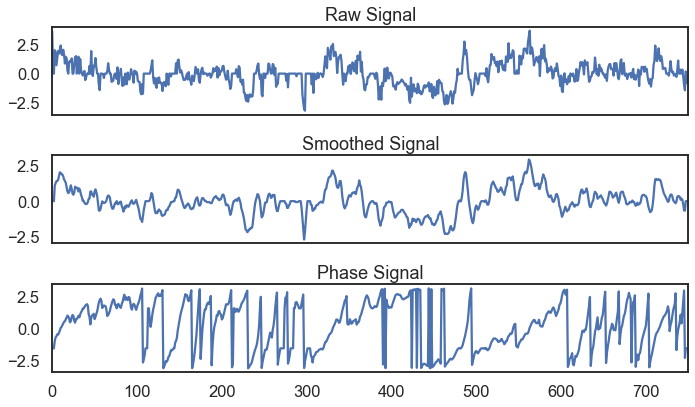

In [6]:
# load data
tseries = np.load(os.path.join(raw_dir, 'compiled_ts_data_movieDM.npy'))
filttseries = np.load(os.path.join(raw_dir, 'smoothed_ts_data_movieDM.npy'))
phase = np.load(os.path.join(out_dir, 'phase_data_movieDM.npy'))

# plot a participant's raw data and phase data (participants #10, region #20)
fig, ax = plt.subplots(3,1, figsize=(10,6), sharex=True)
ax[0].plot(tseries[:,40,10])
ax[0].set_title('Raw Signal')
ax[0].set_xlim((0,750))
ax[1].plot(filttseries[:,40,10])
ax[1].set_title('Smoothed Signal')
ax[2].plot(phase[:,40,10])
ax[2].set_title('Phase Signal')
plt.tight_layout()
plt.show()
plt.close()

### Compute Default mode intra-network dynamic connectivity

In [ ]:
# compute pair-wise network dynamic connectivity
outprefix = os.path.join(out_dir, 'within_network_Default_movieDM_')
mean_ips, ips = compute_ips(net_phase, outprefix, intersub=False, interregion=True, savemean=True)

# save group mean data within
mask = np.tri(mean_ips.shape[0], mean_ips.shape[0], -1, dtype=int)
mean_default_ips = np.mean(mean_ips[mask==1,:], axis=0)
np.save(os.path.join(out_dir, 'group_mean_Default_ips_movieDM.npy'), mean_default_ips)

# save participant-level data
participant_default_ips = np.mean(ips[:,mask==1,:], axis=1)
np.save(os.path.join(out_dir, 'participant_mean_Default_ips_movieDM.npy'), participant_default_ips)

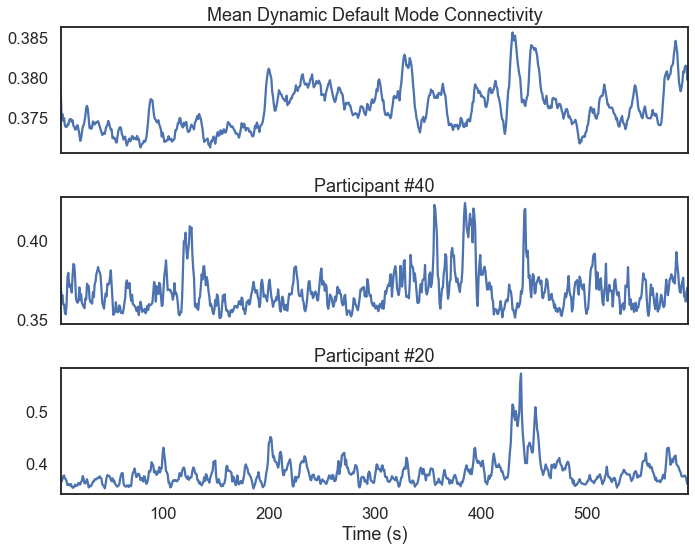

In [10]:
# load data to plot
mean_default_ips = np.load(os.path.join(out_dir, 'group_mean_Default_ips_movieDM.npy'))[5:745]
participant_default_ips = np.load(os.path.join(out_dir, 'participant_mean_Default_ips_movieDM.npy'))[:, 5:745]
time = np.arange(0,600,TR)[5:745]

# plot mean default network dynamic connectivity and 2 subjects
fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].plot(time, mean_default_ips)
ax[0].set_title('Mean Dynamic Default Mode Connectivity')
ax[0].set_xlim((time[0],time[-1]))
ax[1].plot(time, participant_default_ips[40,:])
ax[1].set_title('Participant #40')
ax[2].plot(time, participant_default_ips[20,:])
ax[2].set_title('Participant #20')
ax[2].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()
plt.close()

### Test if overall dynamic connectivity is associated with video content

In [3]:
# load data
video_features_file = os.path.join(vid_dir, 'DM_summary_codes_intuitivenames.csv')
features = pd.read_csv(video_features_file, index_col=0).loc[:, vidfeat_of_interest]

# rescale to 0 to 1 and smooth
from sklearn.preprocessing import MinMaxScaler
features_smooth = pd.DataFrame(index=features.index, columns=features.columns)
features_smooth.loc[:,:] = MinMaxScaler().fit_transform(features.to_numpy())
for c in features.columns:
    features_smooth.loc[:,c] = temporal_smooth(features_smooth[c].to_numpy(), np.arange(0,600,0.8), 1.2)
features_smooth.to_csv(os.path.join(vid_dir, 'DM_summary_codes_smoothed.csv'))
    
# convert signals to phase angles
outfile = os.path.join(vid_dir, 'DM_summary_codes_smoothed_angles.npy')
features_phase = pd.DataFrame(index=features.index, columns=features.columns)
features_phase.loc[:,:] = compute_phase(features_smooth.to_numpy(), outfile)
features_phase.to_csv(os.path.join(vid_dir, 'DM_summary_codes_smoothed_angles.csv'))

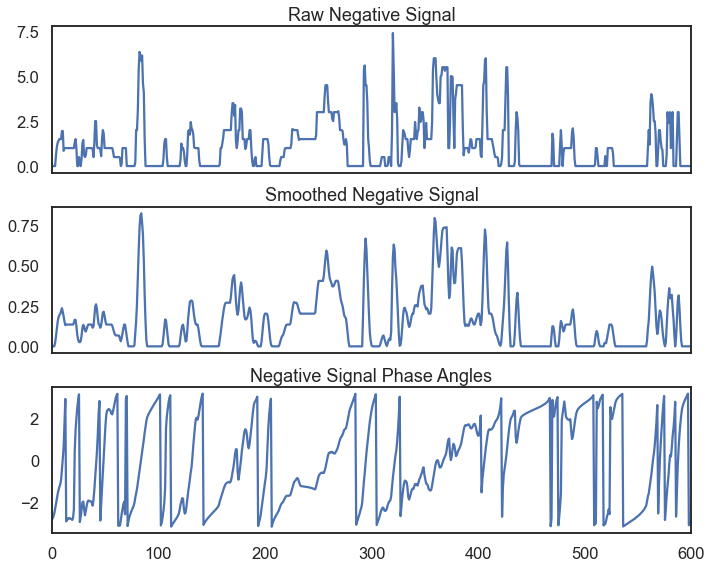

In [4]:
# plot processing of Negative content trace
fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].plot(features['Negative'])
ax[0].set_title('Raw Negative Signal')
ax[0].set_xlim((0,600))
ax[1].plot(features_smooth['Negative'])
ax[1].set_title('Smoothed Negative Signal')
ax[2].plot(features_phase['Negative'])
ax[2].set_title('Negative Signal Phase Angles')
plt.tight_layout()
plt.show()
plt.close()

Default and Positive: Spearman r=-0.33


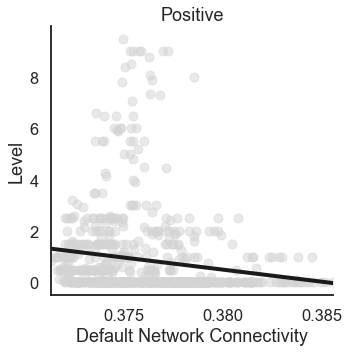

Default and Negative: Spearman r=0.1


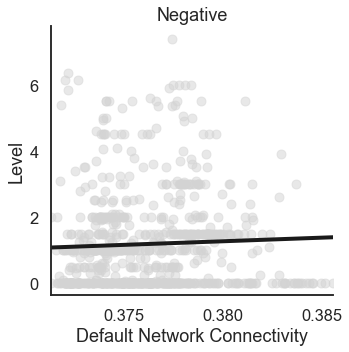

Default and Brightness: Spearman r=0.31


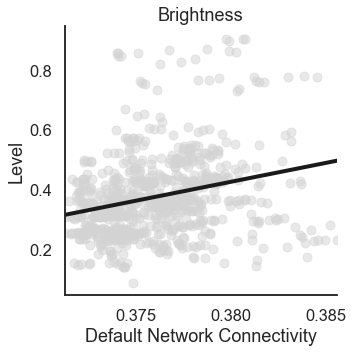

Default and SaliencyFract: Spearman r=0.26


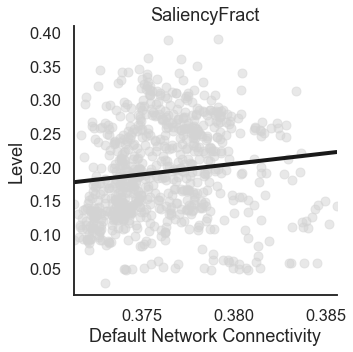

Default and Loudness: Spearman r=0.23


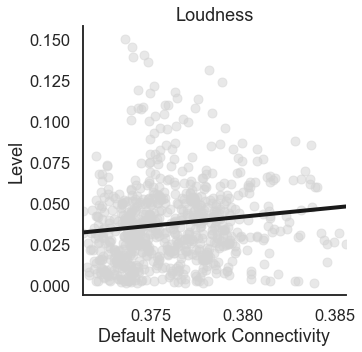

KeyError: 'Default'

In [12]:
# load group data
group_meanDMN = np.load(os.path.join(out_dir, 'group_mean_Default_ips_movieDM.npy'))

data = features
data['Default'] = group_meanDMN
data = data.iloc[5:745,:]

# loop through features and test for overall correlation between Default connectivity and features
for f in features.columns: 
    r,_ = scp.spearmanr(group_meanDMN[5:745],features_smooth[f].to_numpy()[5:745])
    print('Default and {0}: Spearman r={1}'.format(f,round(r,2)))
    sns.lmplot(x='Default',y=f, data=data, ci=None, scatter_kws={'alpha':0.5, 'color':'lightgray'}, 
               line_kws={'lw': 4, 'color':'k'})
    plt.title(f)
    plt.xlabel('Default Network Connectivity')
    plt.ylabel('Level')
    plt.tight_layout()
    plt.show()
    plt.close()

### Test if DMN connectivity is associated with video features for each participant

In [ ]:
## create a null distribution and save
# shuffle phase data
phase = np.load(os.path.join(out_dir, 'phase_data_movieDM.npy'))
print(phase.shape)
phase = np.concatenate([phase, phase], axis=2)
shuff_phase = phase.flatten()
np.random.shuffle(shuff_phase)
np.random.shuffle(shuff_phase)
phase = np.reshape(shuff_phase, phase.shape)
print(phase.shape)
np.save(os.path.join(out_dir, 'null_phase_data_movieDM.npy'), phase)

# create participant and group level null means
outprefix = os.path.join(out_dir, 'null_within_network_Default_movieDM_')
mean_ips, ips = compute_ips(phase[:, network_labels=='Default',:], outprefix, intersub=False, interregion=True, savemean=True)
mask = np.tri(mean_ips.shape[0], mean_ips.shape[0], -1, dtype=int)
mean_default_ips = np.mean(mean_ips[mask==1,:], axis=0)
np.save(os.path.join(out_dir, 'group_null_mean_Default_ips_movieDM.npy'), mean_default_ips)
participant_default_ips = np.mean(ips[:,mask==1,:], axis=1)
np.save(os.path.join(out_dir, 'participant_null_mean_Default_ips_movieDM.npy'), participant_default_ips)

In [15]:
# Compute correlation for each participant across the sample and save
features = pd.read_csv(os.path.join(vid_dir, 'DM_summary_codes_smoothed.csv'), index_col=0)
participant_dmn = np.load(os.path.join(out_dir, 'participant_mean_Default_ips_movieDM.npy'))
null_participant_dmn = np.load(os.path.join(out_dir, 'participant_null_mean_Default_ips_movieDM.npy'))

null_results = pd.DataFrame()
real_results = pd.DataFrame()

for sub in range(0,participant_dmn.shape[0]):
    for f in features.columns:
        real_results.loc[sub,f], p = scp.spearmanr(participant_dmn[sub,4:745],features[f].to_numpy()[4:745])

for sub in range(0,null_participant_dmn.shape[0]):
    for f in features.columns:
        null_results.loc[sub,f], p = scp.spearmanr(null_participant_dmn[sub,4:745],features[f].to_numpy()[4:745])
        
null_results.to_csv(os.path.join(out_dir, 'null_default_feature_correlations_movieDM.csv'))
real_results.to_csv(os.path.join(out_dir, 'real_default_feature_correlations_movieDM.csv'))

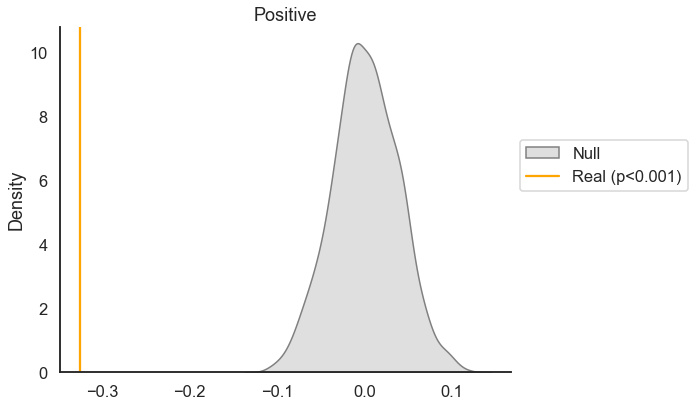

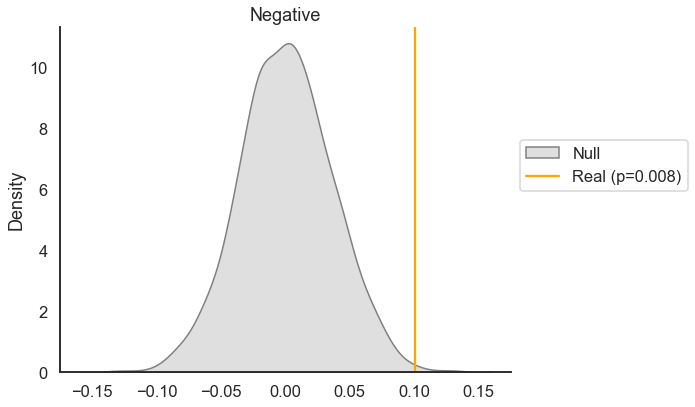

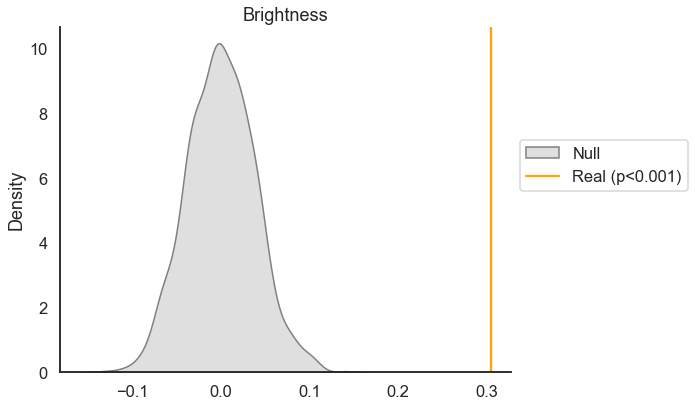

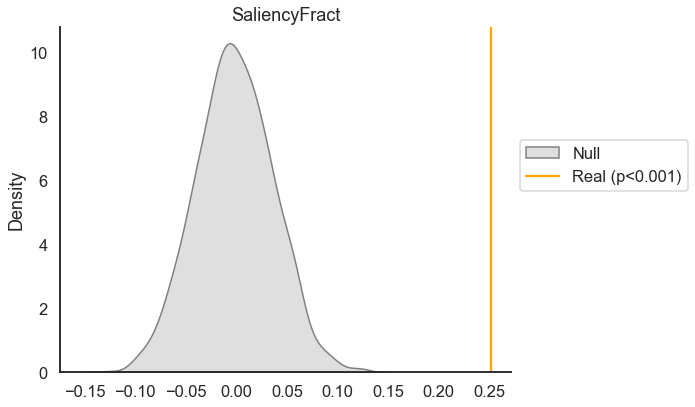

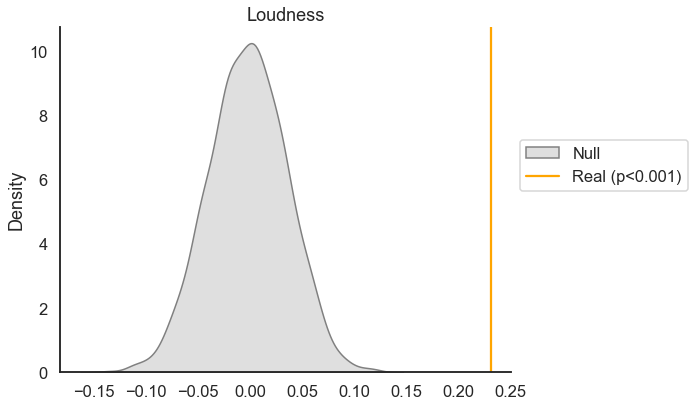

In [16]:
# plot the null distribution and the real value
group_meanDMN = np.load(os.path.join(out_dir, 'group_mean_Default_ips_movieDM.npy'))
for f in features.columns:
    ax = plt.figure(figsize=(10,6))
    r,_ = scp.spearmanr(group_meanDMN[4:745],features[f].to_numpy()[4:745])
    if r>0:
        p = ((np.sum((null_results[f].to_numpy()>=r).astype(int)) + 1) / (null_results.shape[0] + 1))
    elif r<0:
        p = ((np.sum((null_results[f].to_numpy()<=r).astype(int)) + 1) / (null_results.shape[0] + 1))
    if p>(1/null_results.shape[0]):
        p = 'p={0}'.format(round(p*2,3))
    else:
        p = 'p<0.001' 
    sns.kdeplot(null_results.loc[:,f].to_numpy(), label='Null',fill=True, color='gray')
    plt.axvline(x=r, color='orange', label='Real ({0})'.format(p))
    plt.title(f)
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    sns.despine()
    plt.tight_layout()
    plt.show()
    plt.close()

### Test if dynamic connectivity is associated with features at specific times

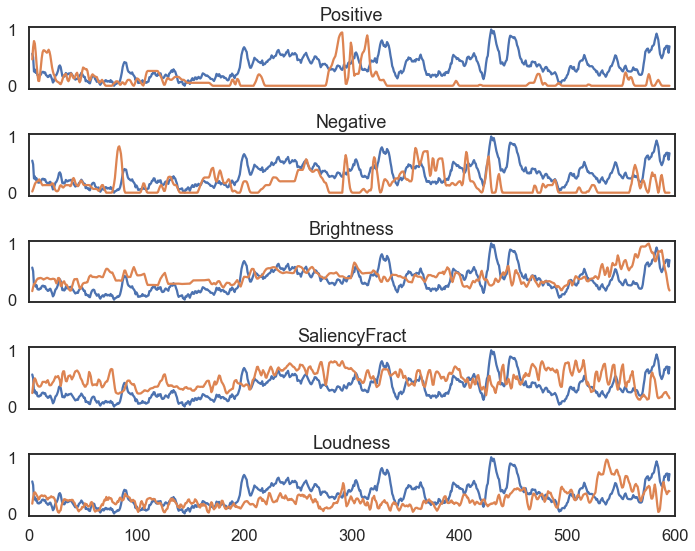

In [3]:
# First, plot the mean DMN dynamic connectivity and each feature (brain data rescaled for plotting purposes only)
group_meanDMN = np.load(os.path.join(out_dir, 'group_mean_Default_ips_movieDM.npy'))
mean_dmn_sd = MinMaxScaler().fit_transform(np.expand_dims(group_meanDMN[4:745], axis=1))
features = pd.read_csv(os.path.join(vid_dir, 'DM_summary_codes_smoothed.csv'), index_col=0)

fig, ax = plt.subplots(features.shape[1], 1, figsize=(10,8), sharex=True, sharey=True)
for i,f in enumerate(features.columns):
    ax[i].plot(features.index[4:745], np.squeeze(mean_dmn_sd), label='Default')
    ax[i].plot(features.index[4:745], features[f].to_numpy()[4:745])
    ax[i].set_title(f)
    ax[i].set_xlim(0,600)
plt.tight_layout()
plt.show()
plt.close()

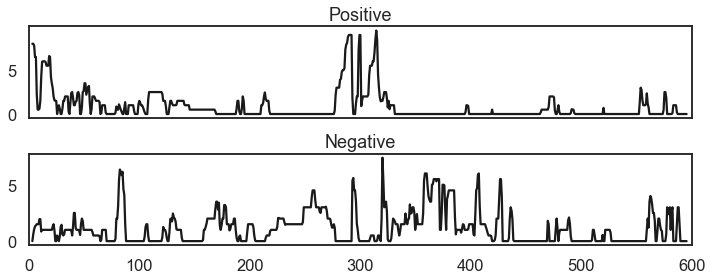

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(10,4), sharex=True, sharey=False)
for i,f in enumerate(features.columns[:2]):
    ax[i].plot(features.index[4:745], features[f].to_numpy()[4:745], color='k')
    ax[i].set_title(f)
    ax[i].set_xlim(0,600)
plt.tight_layout()
plt.show()
plt.close()

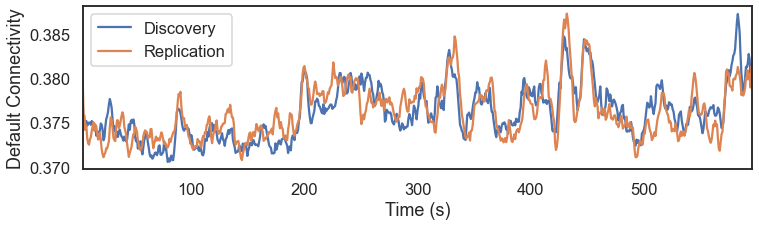

In [4]:
# Next, we need to split our data into a discovery and replication sample
sampleinfo = pd.read_csv(os.path.join(raw_dir, 'sampleinfo_movieDM.csv'), index_col=0)
participant_dmn = np.load(os.path.join(out_dir, 'participant_mean_Default_ips_movieDM.npy'))

discovery = participant_dmn[sampleinfo['site']=='rubic',5:746]
replication = participant_dmn[sampleinfo['site']=='cbic',5:746]

# Compute mean for each site
discovery_mean = np.mean(discovery, axis=0)
replication_mean = np.mean(replication, axis=0)

# plot the mean of each site
time = np.arange(0,600,0.8)[5:746]
plt.figure(figsize=(12,3))
plt.plot(time, discovery_mean, label='Discovery')
plt.plot(time, replication_mean, label='Replication')
plt.xlim(time[0], time[-1])
plt.xlabel('Time (s)')
plt.ylabel('Default Connectivity')
plt.legend()
plt.show()
plt.close()

In [5]:
## within each sample, we will convert the mean connectivity timeseries to phase angles and compute symchrony with our video features
# convert to phase angles
outfile = os.path.join(out_dir, 'discovery_mean_phase_movieDM.npy')
disc_phase = compute_phase(discovery_mean, outfile)
outfile = os.path.join(out_dir, 'replication_mean_phase_movieDM.npy')
rep_phase = compute_phase(replication_mean, outfile)

# load video features phase angles
features_angles = pd.read_csv(os.path.join(vid_dir, 'DM_summary_codes_smoothed_angles.csv'), index_col=0).iloc[5:746,:]

# compute ips for discovery and replication
disc_features_dmn_ips = pd.DataFrame(index=features_angles.index)
rep_features_dmn_ips = pd.DataFrame(index=features_angles.index)
for f in features_angles.columns:
    disc_features_dmn_ips[f] = 1 - np.sin(np.abs(disc_phase - features_angles[f]) / 2)
    rep_features_dmn_ips[f] = 1 - np.sin(np.abs(rep_phase - features_angles[f]) / 2)

array([<AxesSubplot:xlabel='seconds'>, <AxesSubplot:xlabel='seconds'>,
       <AxesSubplot:xlabel='seconds'>, <AxesSubplot:xlabel='seconds'>,
       <AxesSubplot:xlabel='seconds'>], dtype=object)

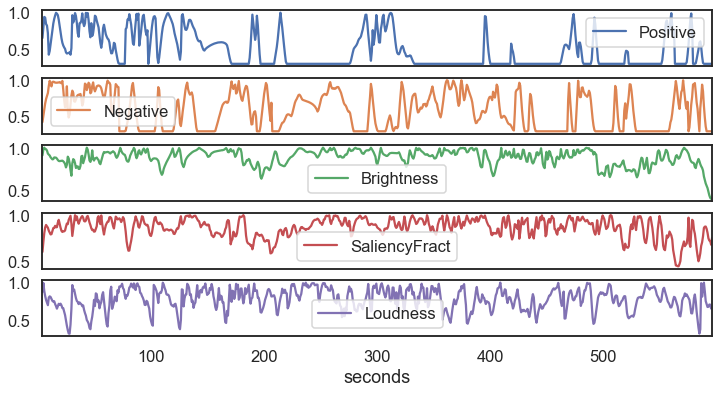

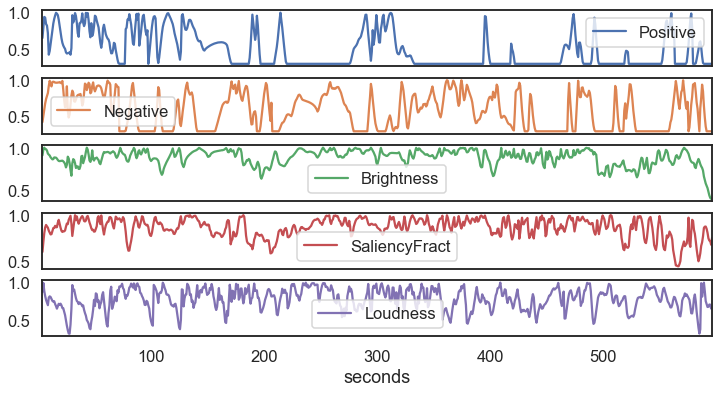

In [6]:
disc_features_dmn_ips.plot(subplots=True, figsize=(12,6), xlim=(time[0],time[-1]))
rep_features_dmn_ips.plot(subplots=True, figsize=(12,6), xlim=(time[0],time[-1]))

In [9]:
# create null distribution for each feature
null_ips = np.load(os.path.join(out_dir, 'participant_null_mean_Default_ips_movieDM.npy'))[:,5:746]
null_ips_flat = null_ips.flatten()
np.random.shuffle(null_ips_flat)
np.random.shuffle(null_ips_flat)
null_ips = np.reshape(null_ips_flat, null_ips.shape)
null_ips_phase = compute_phase(null_ips, os.path.join(out_dir, 'participant_null_mean_phase_Default_ips_movieDM.npy'))

null_feature_default_ips = np.empty((null_ips.shape[0],null_ips.shape[1],len(features_angles.columns)))
for a in range(null_ips.shape[0]):
    for i, f in enumerate(features_angles.columns):
        null_feature_default_ips[a,:,i] = 1 - np.sin(np.abs(null_ips_phase[a,:] - features_angles[f]) / 2)
        
null_distribution = null_feature_default_ips.flatten()
np.save(os.path.join(out_dir, 'null_feature_default_ips_distribution_movieDM.npy'), null_distribution)

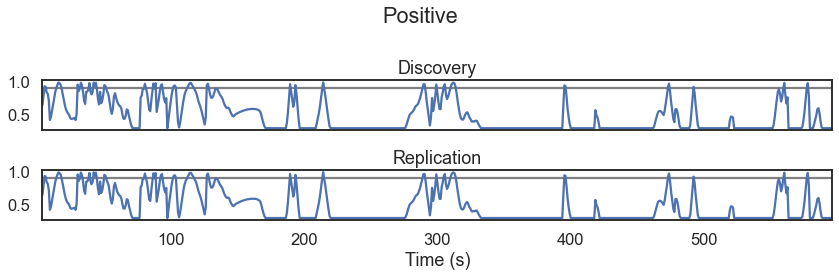

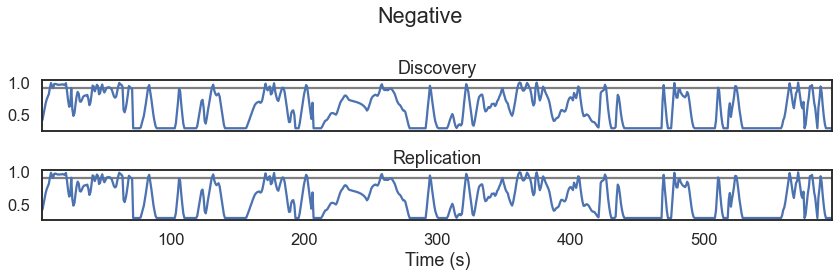

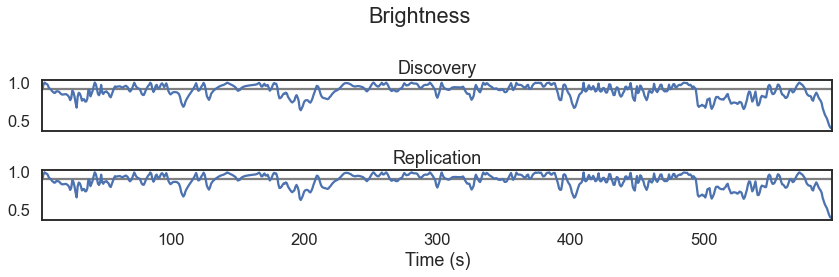

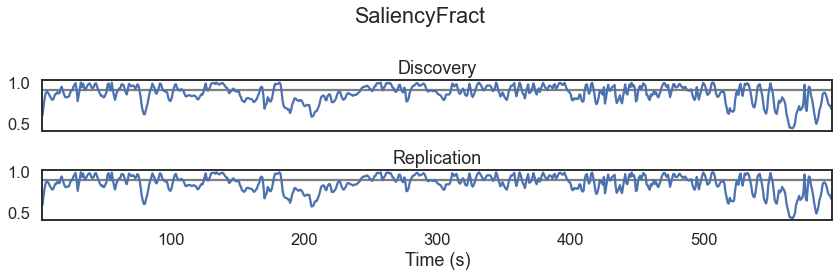

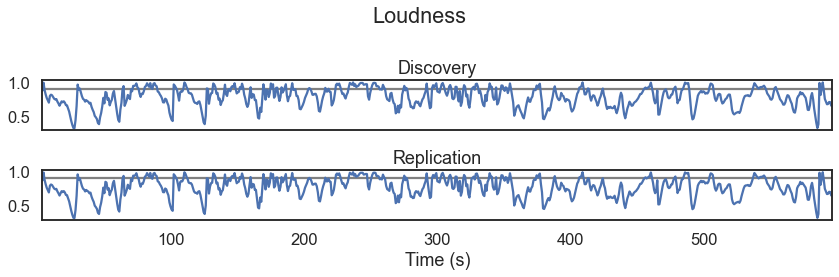

In [10]:
# now lets plot each site with the null distribution
null_cutoff = np.percentile(null_distribution, 95)

for j, f in enumerate(features.columns):
    fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12,4))
    ax[0].axhline(null_cutoff, label='top', color='gray')
    ax[0].plot(time, disc_features_dmn_ips[f], label='Discovery')
    ax[0].set_title('Discovery')
    ax[1].axhline(null_cutoff, label='top', color='gray')
    ax[1].plot(time, rep_features_dmn_ips[f], label='Replication')
    ax[1].set_title('Replication')
    ax[1].set_xlim(time[0], time[-1])
    plt.xlabel('Time (s)')
    plt.suptitle(f)
    plt.tight_layout()
    plt.show()
    plt.close()

We can see that not many points of the video are above the null cut off.  Let's graph these results a different way.

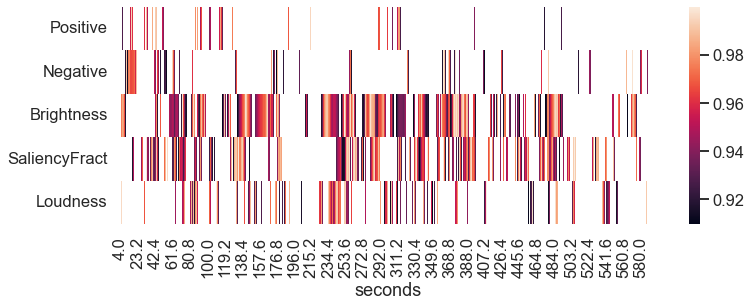

In [11]:
# mask out non-significant timepoints and plot the discovery sample
disc_features_dmn_ips_masked = disc_features_dmn_ips
disc_features_dmn_ips_masked[(disc_features_dmn_ips<null_cutoff) | (rep_features_dmn_ips<null_cutoff)] = np.nan

plt.figure(figsize=(12,4))
sns.heatmap(disc_features_dmn_ips_masked.T)
plt.show()
plt.close()

Looking at it in the heatmap, there are many short segments where Default connectivity changes with video features.  We know that the hemodynamic response takes about 4 seconds, however. Let's remove segments from here that are less than 4 seconds long, since they are not likely to be meaningful.

In [12]:
# set up dataframe with mask
keep_df = ((disc_features_dmn_ips>null_cutoff) & (rep_features_dmn_ips>null_cutoff)).astype(int)
results = {}

for i,f in enumerate(disc_features_dmn_ips_masked.columns):
    sig = pd.DataFrame()
    sig['time'] = disc_features_dmn_ips.index
    sig['both'] = keep_df[f].to_numpy()
    sig['segment'] = (sig['both'].diff(1) != 0).astype(int).cumsum()

    segments = pd.DataFrame({'start': sig.groupby('segment').time.first(),
                             'end': sig.groupby('segment').time.last(),
                             'dur': sig.groupby('segment').time.last()-sig.groupby('segment').time.first(),
                             'mask_value': sig.groupby('segment')['both'].mean()}).reset_index(drop=True)
    segs_to_delete = segments.loc[(segments['mask_value'] == 1) & (segments['dur']<4), :]
    if len(segs_to_delete)>0:
        segments = segments.loc[(segments['mask_value'] == 1) & (segments['dur']>=4), :]
        for a in segs_to_delete.index:
            start = segs_to_delete.loc[a, 'start']
            end = segs_to_delete.loc[a, 'end']
            if start==end:
                keep_df.loc[start, f] = 0
            else:
                keep_df.loc[start:end, f] = 0
    results[f] = segments

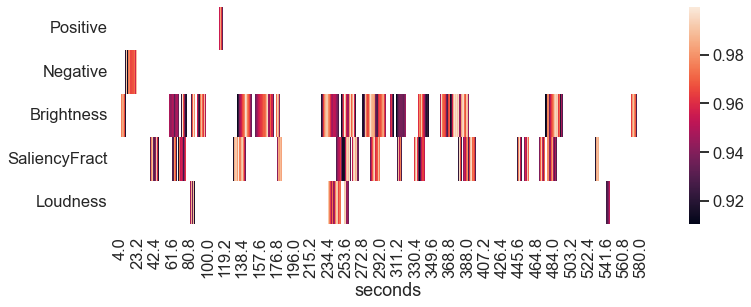

In [13]:
# now lets remove the short segments from our plot
disc_features_dmn_ips_masked.values[keep_df.to_numpy()==0] = np.nan

plt.figure(figsize=(12,4))
sns.heatmap(disc_features_dmn_ips_masked.T)
plt.show()
plt.close()

From the above plot, we can see that there is meaningful change in dynamic default mode connectivity with changes in saliency fraction and brightness in certain scenes, but not for changes in Positive or Negative content. 

In [14]:
# save csv with segments for each video feature
results['Positive'].to_csv(os.path.join(out_dir,'dynamic_synchrony_default_positive_sig_movieDM.csv'))
results['Negative'].to_csv(os.path.join(out_dir,'dynamic_synchrony_default_negative_sig_movieDM.csv'))
results['Brightness'].to_csv(os.path.join(out_dir,'dynamic_synchrony_default_brightness_sig_movieDM.csv'))
results['SaliencyFract'].to_csv(os.path.join(out_dir,'dynamic_synchrony_default_saliency_sig_movieDM.csv'))
results['Loudness'].to_csv(os.path.join(out_dir,'dynamic_synchrony_default_loudness_sig_movieDM.csv'))